https://www.bioconductor.org/packages/devel/bioc/vignettes/splatter/inst/doc/splatter.html

In [1]:
library(splatter)
library(Seurat)
library(dplyr)
library(scater)
library(mclust)
library(plyr)

data("sc_example_counts")

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, rank, rbind,
    rowMeans, rowSums, r

In [2]:
seurat_preprocess <- function(data, scale=TRUE){
    # Create seurat object
    obj <- CreateSeuratObject(raw.data = data, min.cells = 3, min.genes = 200)
    
    # Filter out cells based on percentage of mitochondrial genes
    mito.genes <- grep(pattern = "^MT-", x = rownames(x = obj@data), value = TRUE)
    percent.mito <- Matrix::colSums(obj@raw.data[mito.genes, ])/Matrix::colSums(obj@raw.data)
    obj <- AddMetaData(object = obj, metadata = percent.mito, col.name = "percent.mito")
    
    # Normalize data
    obj <- NormalizeData(object = obj, normalization.method = "LogNormalize", 
        scale.factor = 10000)
    
    # Filter out only variable genes
    obj <- FindVariableGenes(object = obj, mean.function = ExpMean, dispersion.function = LogVMR, 
        x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5, do.plot = FALSE)
    
    # Regress out unwanted sources of variation
    if (scale){
        obj <- ScaleData(object = obj, vars.to.regress = c("nUMI", "percent.mito"))
    }
    
    return(obj)
}

seurat_pipeline <- function(data, resolution=0.6){
    
    obj <- seurat_preprocess(data)
    
    # PCA
    obj <- RunPCA(object = obj, pc.genes = obj@var.genes, do.print = FALSE)
    obj <- ProjectPCA(object = obj, do.print = FALSE)
    
    # Run clustering using computed PCs
    obj <- FindClusters(object = obj, reduction.type = "pca", dims.use = 1:10, 
        resolution = resolution, print.output = 0, save.SNN = TRUE)
    
    return(obj)
}

Regressing out: nUMI, percent.mito



Time Elapsed:  27.7200572490692 secs

Scaling data matrix


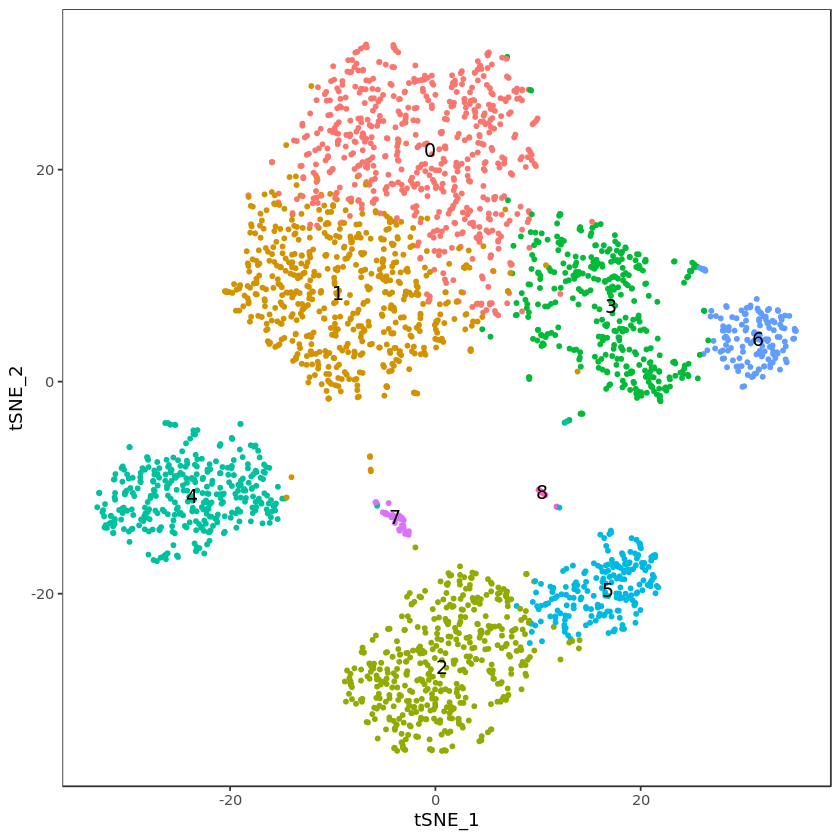

In [3]:
pbmc.data <- Read10X(data.dir = "filtered_gene_bc_matrices/hg19/")
pbmc <- seurat_pipeline(pbmc.data, resolution = 0.8)
pbmc <- RunTSNE(object = pbmc, dims.use = 1:10, do.fast = TRUE)
plot <- TSNEPlot(object = pbmc, do.return = TRUE, no.legend = TRUE, do.label = TRUE)
plot_grid(plot)

M = as.data.frame(as.matrix(pbmc@data))
write.table(M, file = sprintf('pbmc_seurat_preprocessed.txt'))
write.table(pbmc@ident, file = sprintf('pbmc_seurat_labels.txt'))
write.table(pbmc@dr$tsne@cell.embeddings, file = sprintf('pbmc_seurat_tsne.txt'))

In [4]:
# Grab clusters 0 and 1
c0cells <- WhichCells(object = pbmc, ident = 0, random.seed = 1)
c0cells1 <- sample(c0cells, size=floor(length(c0cells)/2))
c1cells <- WhichCells(object = pbmc, ident = 1, random.seed = 1)
c1cells1 <- sample(c1cells, size=floor(length(c1cells)/2))
ctest.data = pbmc@raw.data[, c(c0cells1, c1cells1), drop = F]

ctest <- seurat_pipeline(ctest.data)
write.table(c(c0cells1, c1cells1), file = sprintf('pbmc_splatter_0v1_cellsamp1.txt'))
write.table(ctest@ident, file = sprintf('pbmc_splatter_0v1_cellsamplabels1.txt'))
table(ctest@ident, pbmc@ident[c(c0cells1, c1cells1)])

Regressing out: nUMI, percent.mito



Time Elapsed:  12.7409245967865 secs

Scaling data matrix


   
      0   1   2   3   4   5   6   7   8
  0  75 229   0   0   0   0   0   0   0
  1 214  57   0   0   0   0   0   0   0

In [5]:
x <- vector(length=10)
p_list <- 1:10/10
c0cells <- WhichCells(object = pbmc, ident = 0, random.seed = 1)
c1cells <- WhichCells(object = pbmc, ident = 1, random.seed = 1)
for (i in 1:length(p_list)){
    p <- p_list[i]
    c0cells1 <- sample(c0cells, size=floor(length(c0cells)*p))
    c1cells1 <- sample(c1cells, size=floor(length(c1cells)*p))
    ctest.data = pbmc@raw.data[, c(c0cells1, c1cells1), drop = F]
    ctest <- seurat_pipeline(ctest.data)
    orig_labels <- droplevels(pbmc@ident[c(c0cells1, c1cells1)])
    x[i] <- adjustedRandIndex(ctest@ident, orig_labels)
    print(table(ctest@ident, orig_labels))
}

Regressing out: nUMI, percent.mito



Time Elapsed:  8.9353563785553 secs

Scaling data matrix


   orig_labels
     0  1
  0 57 57


Regressing out: nUMI, percent.mito



Time Elapsed:  10.4109251499176 secs

Scaling data matrix


   orig_labels
      0   1
  0 115 114


Regressing out: nUMI, percent.mito



Time Elapsed:  11.0105216503143 secs

Scaling data matrix


   orig_labels
      0   1
  0  90 105
  1  83  66


Regressing out: nUMI, percent.mito



Time Elapsed:  11.1994292736053 secs

Scaling data matrix


   orig_labels
      0   1
  0 167  72
  1  64 156


Regressing out: nUMI, percent.mito



Time Elapsed:  12.6932034492493 secs

Scaling data matrix


   orig_labels
      0   1
  0  79 210
  1 210  76


Regressing out: nUMI, percent.mito



Time Elapsed:  13.5717482566833 secs

Scaling data matrix


   orig_labels
      0   1
  0 277  77
  1  70 266


Regressing out: nUMI, percent.mito



Time Elapsed:  14.3504207134247 secs

Scaling data matrix


   orig_labels
      0   1
  0 113 332
  1 292  68


Regressing out: nUMI, percent.mito



Time Elapsed:  14.4194943904877 secs

Scaling data matrix


   orig_labels
      0   1
  0 120 356
  1 343 101


Regressing out: nUMI, percent.mito



Time Elapsed:  13.789678812027 secs

Scaling data matrix


   orig_labels
      0   1
  0 427 149
  1  94 365


Regressing out: nUMI, percent.mito



Time Elapsed:  16.3859441280365 secs

Scaling data matrix


   orig_labels
      0   1
  0 440 136
  1 112 429
  2  27   7
